In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, jit, grad

key = jax.random.key(1234)

In [2]:
# Constants:
n_x = 2
n_u = 1
n_z = 1
DT = 0.01

In [3]:
# Vectorized rk4
def rk4(f, x, u):
    f = vmap(f, in_axes=(0,0))
    k1 = f(x          , u) 
    k2 = f(x + DT*k1/2, u)
    k3 = f(x + DT*k2/2, u)
    k4 = f(x + DT*k3  , u) 
    return x + (DT/6) * (k1 + 2*k2 + 2*k3 + k4)

In [4]:
# System dynamics 
def double_integrator(x, u):
    return jnp.array([x[1], u[0]])

In [18]:
# Generate random initial conditions
N_traj = 1000
x = jax.random.normal(key, (N_traj, 2))
X = [x]

# Horizon
T = 0.1

# Evolve with random control inputs
rk4 = jax.jit(rk4, static_argnums=0)
keys = jax.random.split(key, int(T/DT))
U = []
for t in range(int(T/DT)):
    u = 10*jax.random.normal(keys[t], (N_traj, 1))
    x = rk4(double_integrator, x, u)
    X.append(x)
    U.append(u)
    
X = jnp.array(X)
X = jnp.einsum('ijk->jik', X)

U = jnp.array(U)
U = jnp.einsum('ijk->jik', U)

print("X data shape", X.shape)
print("U data shape", U.shape)
filtered_inds = (jnp.abs(X[:,-1,0]) < jnp.abs(X[:,0,0])) * (jnp.abs(X[:,-1,1]) < jnp.abs(X[:,0,1]))
X = X[filtered_inds]
U = U[filtered_inds]
print("filtered X shape", X.shape)
print("filtered U shape", U.shape)

X data shape (1000, 11, 2)
U data shape (1000, 10, 1)
filtered X shape (221, 11, 2)
filtered U shape (221, 10, 1)


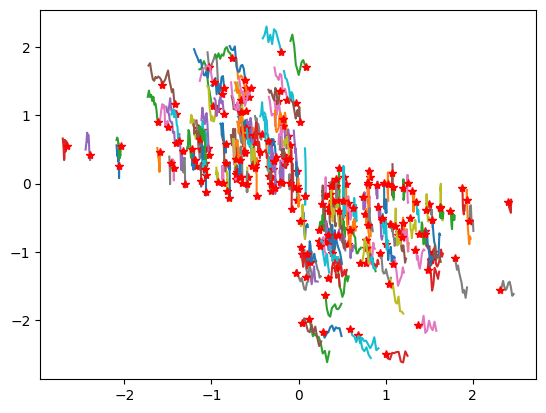

In [19]:
# Plot random stabilizing trajecotries
for i in range(X.shape[0]):
    plt.plot(X[i,:,0], X[i,:,1])
    plt.plot(X[i,-1,0], X[i,-1,1], 'r*')
plt.show()

In [36]:
import flax.linen as nn
from flax.training import train_state
import optax
import numpy as np
from functools import partial
from jax import lax

In [37]:
class SimpleMLP(nn.Module):
    num_hidden: int
    num_outputs: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [38]:

# Create a subclass of TrainState to add a new metric
class CustomTrainState(train_state.TrainState):
    # You can add any other metric here, e.g., batch stats for BatchNorm
    loss: float

# 1. Instantiate the model
encoder = SimpleMLP(num_hidden=n_x, num_outputs=n_z)
fz = SimpleMLP(num_hidden=n_z+n_u, num_outputs=n_z)
dummy_input = jnp.ones([1, 10]) # Shape: (batch_size, num_features)

# 2. Initialize the model parameters
# We need to split the key for deterministic initialization
enc_init_key, fz_init_key, enc_apply_key, fz_apply_key = jax.random.split(key, 4)
params_enc = encoder.init(enc_init_key, dummy_input)['params']
params_fz = fz.init(fz_init_key, dummy_input)['params']

# 3. Define the optimizer
learning_rate = 0.01
optimizer_enc = optax.adam(learning_rate)
optimizer_fz = optax.adam(learning_rate)

# 4. Create the TrainState instance
enc_state = CustomTrainState.create(
    apply_fn=encoder.apply,
    params=params_enc,
    tx=optimizer_enc,
    loss=0.0 # Initialize our custom metric
)

fz_state = CustomTrainState.create(
    apply_fn=fz.apply,
    params=params_fz,
    tx=optimizer_fz,
    loss=0.0 # Initialize our custom metric
)


In [39]:

@jax.jit
def train_step(enc_state, fz_state, batch):
    """A single JIT-compiled training step."""
    # Unpack the batch
    #inputs, targets = batch
    x_batch, U_batch = batch

    def _compute_fwd_loss_single_trajectory(enc_params, fz_params, x, U, T): #, encoder, latent_dynamics_st):
        """
        Computes the total forward loss for a SINGLE trajectory.
        This function is designed to be vmapped over a batch of trajectories.
        The `latent_dynamics_step` argument is now a function that performs a single step.
        """
        # The outer loop of the loss is over the time horizon `t`.
        # We use lax.scan for an efficient, JIT-compilable loop. This part is unchanged.
        def t_loop_body(carry, t):
            fwd_loss_acc = carry
            
            # The inner loop is over the start time `k`.
            # We can vectorize this loop fully using `jax.vmap`. This is also unchanged.
            k_max = T - t
            k_indices = jnp.arange(k_max)
    
            def k_loop_body(k_idx):
                # This function computes the loss term for a single (k, t) pair.
                
                # Get the initial state x_k and target state x_{k+t}.
                x_k = x[k_idx]
                x_k_plus_t = x[k_idx + t]
    
                # The control sequence U_{k,k+t} has length `t` and starts at `k_idx`.
                U_slice = lax.dynamic_slice(U, (k_idx, 0), (t, U.shape[-1]))
    
                # Encode initial and target states.
                #z_k = encoder(params, x_k)
                z_k = enc_state.apply_fun({'params': enc_params}, x_k)
                z_k_plus_t_target = encoder(params, x_k_plus_t)
    
                # --- MODIFIED LOGIC ---
                # Instead of a single model call, we now perform a t-step rollout
                # using the one-step `latent_dynamics_step` model.
                # We use `lax.scan` to efficiently apply the one-step model `t` times.
                
                def rollout_step(carry_z, u_t_slice):
                    # carry_z: the latent state from the previous step.
                    # u_t_slice: the control for the current step.
                    # The one-step model is called here.
                    #next_z = latent_dynamics_step(params, carry_z, u_t_slice)
                    
                    next_z = fz_state.apply_fun({'params': fz_params}, jnp.concat([carry_z, u_t_slice]))
                    # We only need to carry the state forward; no per-step output is needed.
                    return next_z, None 
    
                # The scan starts with the initial latent state `z_k` and iterates
                # over the control sequence `U_slice`.
                # The final result of the scan is the predicted latent state at time k+t.
                z_k_plus_t_pred, _ = lax.scan(rollout_step, z_k, U_slice)
                
                fwd_term = jnp.sum((z_k_plus_t_target - z_k_plus_t_pred)**2)
                return fwd_term
    
            # Vmap the inner function over all valid `k` indices for the current `t`.
            fwd_terms = jax.vmap(k_loop_body)(k_indices)
            fwd_loss_acc += jnp.sum(fwd_terms)
            return fwd_loss_acc, None

        initial_carry = 0.0
        t_values = jnp.arange(1, T)
        total_fwd_loss, _ = lax.scan(t_loop_body, initial_carry, t_values)
        return total_fwd_loss

    #@partial(jax.jit, static_argnames=('encoder', 'latent_dynamics_step'))
    def fwd_loss(enc_params, fz_params): #, x_batch, U_batch, encoder, latent_dynamics_step):
        """
        Computes the total jittable forward loss for a batch of trajectories.
        Corresponds to the L_fwd equation.
        The `latent_dynamics_step` argument has been updated.
        """
        N, T, _ = x_batch.shape
        
        single_loss_fn = partial(_compute_fwd_loss_single_trajectory, T=T)
    
        #fwd_losses = jax.vmap(
        #    single_loss_fn, in_axes=(None, 0, 0, None, None)
        #)(params, x_batch, U_batch, encoder, latent_dynamics_step)
        fwd_losses = jax.vmap(
            single_loss_fn, in_axes=(None, None, 0, 0)
        )(enc_params, fz_params, x_batch, U_batch)
        
        return jnp.sum(fwd_losses) / N  

    def loss_fn(params):
        """Calculates the loss for a given set of parameters."""
        # The 'apply_fn' is the model's forward pass
        predictions = state.apply_fn({'params': params}, inputs)
        # We'll use a simple Mean Squared Error loss
        loss = jnp.mean((predictions - targets) ** 2)
        return loss

    # Use jax.grad to get the gradient function
    # The 'has_aux=False' means the loss_fn only returns one value (the loss).
    # If it returned more (e.g., loss, accuracy), you'd use has_aux=True.
    grad_fn = jax.value_and_grad(fwd_loss)
    loss, grads = grad_fn(enc_state.params, fz_state.params)

    # Use state.apply_gradients to update the parameters and optimizer state
    # This automatically handles the optimizer logic (e.g., Adam updates)
    state = state.apply_gradients(grads=grads)
    
    # We can also update our custom metrics in the state
    state = state.replace(loss=loss)
    
    return state
    

In [40]:

# Generate some dummy data for training
'''
num_samples = 1000
num_features = 10
X = np.random.rand(num_samples, num_features)
# A simple linear relationship for the target
y = X @ np.random.rand(num_features, 1) + 0.5
'''
num_samples = X.shape[0] 

# --- Training Loop ---
num_epochs = 20
batch_size = 32
num_steps_per_epoch = num_samples // batch_size

print("Starting training...")
for epoch in range(num_epochs):
    # Simple data shuffling
    perm = np.random.permutation(num_samples)
    #X_shuffled, y_shuffled = X[perm], y[perm]
    X_shuffled, U_shuffled = X[perm], U[perm]

    for step in range(num_steps_per_epoch):
        # Create a batch
        start_idx = step * batch_size
        end_idx = start_idx + batch_size
        batch = (X_shuffled[start_idx:end_idx], U_shuffled[start_idx:end_idx])

        # Execute the training step
        state = train_step(enc_state, fz_state, batch) # state is updated here!

    # Print the loss from the last step of the epoch
    print(f"Epoch {epoch+1}, Loss: {state.loss:.4f}")
    
print("Training finished.")


Starting training...


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
It arose in the jnp.arange argument 'stop'
The error occurred while tracing the function t_loop_body at /tmp/SLURM_2052293/ipykernel_2809033/3468373369.py:16 for scan. This concrete value was not available in Python because it depends on the value of the argument t.

See https://docs.jax.dev/en/latest/errors.html#jax.errors.ConcretizationTypeError